# Denoising diffusion (2D Swiss roll)

Generative modeling with DDPMs is demonstrated on the basis of a 2D version of the good old Swiss roll data set. The example merely serves the purpose of quickly familiarizing with the algorithm and its properties. Most of the model architecture or hyperparameter choices are quite arbitrary.

You can run `python train_ddpm_swissroll.py` in the main folder in order to train a simple diffusion model. The script relies on the library Lightning for training, logging and checkpointing. When experimenting with with different model setups, or actually almost always, you may want to monitor the training and validation losses. This can be done through `tensorboard --logdir run/swissroll/` for example.

After the model has been trained, it can be imported and tested in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from lightning.pytorch import seed_everything

from diffusion import make_swiss_roll_2d, DDPMTab

In [3]:
_ = seed_everything(111111)  # set random seeds manually

Seed set to 111111


## Swiss roll data

A synthetic test set is generated in the following, totalling $N=1000$ samples $\{\boldsymbol{x}_{0,i}\}_{i=1}^N$. They are created with the function `make_swiss_roll_2d`, which is called with the same parameter values that were already used for the training data.

In [4]:
x_test = make_swiss_roll_2d(
    num_samples=1000,
    noise_level=0.5,
    scaling=0.15,
    random_state=None,
    test_size=None
)

x_test = torch.tensor(x_test, dtype=torch.float32)

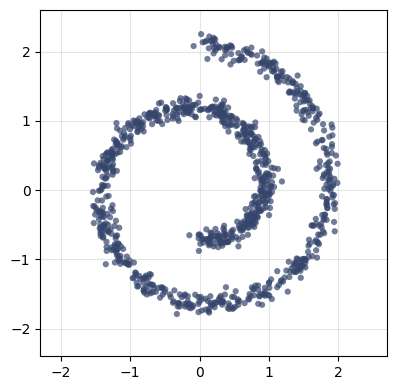

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    x_test[:,0].numpy(), x_test[:,1].numpy(), s=20,
    edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2)
)
ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
ax.set_aspect('equal', adjustable='box')
ax.grid(color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## DDPM import

Our trained model is now imported. A `DDPMTab`-object is initialized accordingly to that end. It provides methods for the forward and reverse process and allows for computing the loss $L_{\text{simple}} = \mathbb{E}_{\mathcal{U}(t|1, T), q(\boldsymbol{x}_0), \mathcal{N}(\boldsymbol{\epsilon} | \boldsymbol{0}, \boldsymbol{I})}[\lVert \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t) \rVert^2]$. The diffusion process consists of $T=500$ time steps. Note that, very probably, one could even get away with a smaller number. The noise model $\boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t)$ is composed of fully connected layers and ReLU activations. Every layer is explicitly conditioned on the time $t$.

In [6]:
ckpt_file = '../run/swissroll/version_0/checkpoints/last.ckpt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ddpm = DDPMTab.load_from_checkpoint(ckpt_file)

ddpm = ddpm.eval()
ddpm = ddpm.to(device)

The noise schedule represents an important model setting. Therefore, $\beta_t$ and $\sqrt{\bar{\alpha}_t}$ as well as the log-SNR corresponding to the selected schedule are plotted below for all $t=1,\ldots,500$.

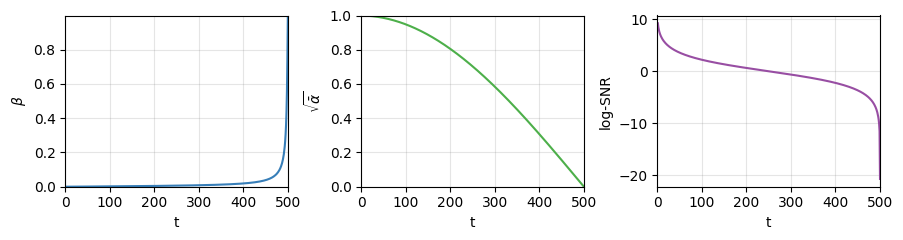

In [7]:
betas = ddpm.betas.cpu().numpy()
alphas_bar = ddpm.alphas_bar.cpu().numpy()
log_snr = np.log(alphas_bar / (1 - alphas_bar))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 2.5))

ax1.plot(np.arange(len(betas)) + 1, betas, color=plt.cm.Set1(1))
ax1.set(xlim=(0, len(ddpm.betas)), ylim=(0, ddpm.betas.max().item()))
ax1.set(xlabel='t', ylabel='$\\beta$')
ax1.grid(color='gray', alpha=0.2, linestyle='-')
ax1.set_axisbelow(True)

ax2.plot(np.arange(len(alphas_bar)) + 1, np.sqrt(alphas_bar), color=plt.cm.Set1(2))
ax2.set(xlim=(0, len(ddpm.alphas_bar)), ylim=(0, 1))
ax2.set(xlabel='t', ylabel='$\\sqrt{\\bar{\\alpha}}$')
ax2.grid(color='gray', alpha=0.2, linestyle='-')
ax2.set_axisbelow(True)

ax3.plot(np.arange(len(log_snr)) + 1, log_snr, color=plt.cm.Set1(3))
ax3.set(xlim=(0, len(ddpm.alphas_bar)))
ax3.set(xlabel='t', ylabel='log-SNR')
ax3.grid(color='gray', alpha=0.2, linestyle='-')
ax3.set_axisbelow(True)

fig.tight_layout()

## Forward process

It is interesting to visualize the forward diffusion process applied to the problem at hand. To that end, the training data are diffused step by step according to $q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{1-\beta_t} \boldsymbol{x}_{t-1}, \beta_t \boldsymbol{I})$ with the method `diffuse_all_steps`. Intermediate results for certain time steps can then be plotted. This allows us to observe the advancing diffusion process from data to pure noise "in action".

In [8]:
x_noisy = ddpm.diffuse_all_steps(x_test.to(device)).cpu()

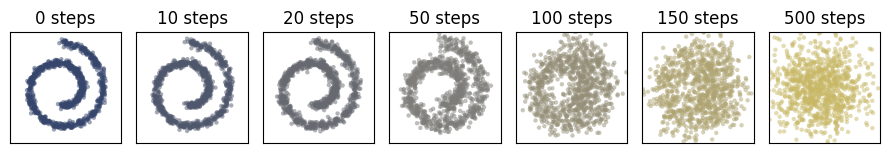

In [9]:
plot_steps = [0, 10, 20, 50, 100, 150, 500]
colors = plt.cm.cividis(np.linspace(0.2, 0.8, len(plot_steps)))

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps), figsize=(9, 2))
for time_idx, color, ax in zip(plot_steps, colors, axes.ravel()):
    samples = x_noisy[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, edgecolors='none', alpha=0.5, color=color)
    ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

It is noted that the simulation of $q(\boldsymbol{x}_t | \boldsymbol{x}_0) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, (1-\bar{\alpha}_t) \boldsymbol{I})$ at any time step directly is enabled by the method `diffuse`.

## Generative process

After having trained the model, the denoising process can be used for data generation. The `denoise_all_steps` method allows one to perform $p_{\boldsymbol{\theta}}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t) = \mathcal{N}(\boldsymbol{x}_{t-1} | \boldsymbol{\mu}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t), \sigma_t^2 \boldsymbol{I})$ with $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t) = \frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t))$ in step-wise fashion. This way, the progressive generation can be visualized for intermediate steps. The evolution from pure noise into the targeted spiral-shaped structure can be observed.

In [10]:
x_noise = torch.randn(1000, 2)
x_denoise = ddpm.denoise_all_steps(x_noise.to(device)).cpu()

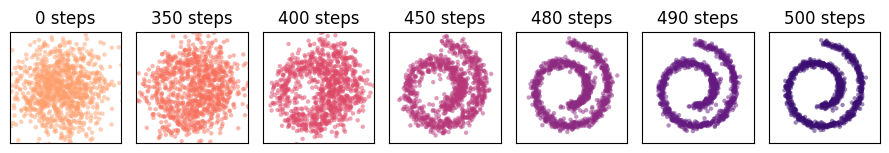

In [11]:
reverse_plot_steps = [ddpm.num_steps - s for s in reversed(plot_steps)]
reverse_colors = plt.cm.magma(np.linspace(0.8, 0.2, len(reverse_plot_steps)))

fig, axes = plt.subplots(nrows=1, ncols=len(reverse_plot_steps), figsize=(9, 2))
for time_idx, color, ax in zip(reverse_plot_steps, reverse_colors, axes.ravel()):
    samples = x_denoise[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, edgecolors='none', alpha=0.5, color=color)
    ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

The same process is also implemented by `generate`, without storing intermediate results though. We use this method to generate some final samples.

In [12]:
x_gen = ddpm.generate(sample_shape=(2,), num_samples=1000).cpu()

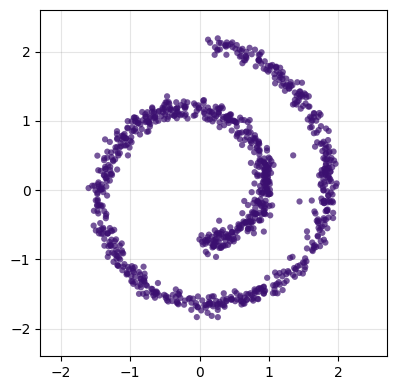

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(
    x_gen[:,0].numpy(), x_gen[:,1].numpy(), s=20,
    edgecolors='none', alpha=0.7, color=reverse_colors[-1]
)
ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
ax.set_aspect('equal', adjustable='box')
ax.grid(color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

Well, it seems to work!